In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
pd.set_option('mode.chained_assignment', None)
import geopandas as gpd

In [2]:
df = pd.read_csv("/media/rghoshal/D4A6E10AA6E0EE441/UGP/datasets/data.csv",index_col = 0)

In [3]:
# Oceanic divide
time = pd.DatetimeIndex(df["time"].unique())
indian_ocean = df[(df["lat"] < 8) & (df["sla"].isnull() == False)]
arabian_sea = df[(df["lat"] > 8) & (df["lon"] < 77.5) & (df["sla"].isnull() == False)]
bay_bangal = df[(df["lat"] > 8) & (df["lon"] > 77.5) & (df["sla"].isnull() == False)]

s1 = indian_ocean["sla"].groupby(pd.DatetimeIndex(indian_ocean['time'])).mean()
s2 = arabian_sea["sla"].groupby(pd.DatetimeIndex(arabian_sea['time'])).mean()
s3 = bay_bangal["sla"].groupby(pd.DatetimeIndex(bay_bangal['time'])).mean()

In [4]:
# Land Divide

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))
region1 = gpd.read_file('region1.geojson')
region2 = gpd.read_file('region2.geojson')
region3 = gpd.read_file('region3.geojson')
region4 = gpd.read_file('region4.geojson')

In [5]:
mask_region1 = (region1.loc[0, 'geometry'])
mask_region2 = (region2.loc[0, 'geometry'])
mask_region3 = (region3.loc[0, 'geometry'])
mask_region4 = (region4.loc[0, 'geometry'])
gdf.loc[:,'region1'] = gdf.within(mask_region1)
gdf.loc[:,'region2'] = gdf.within(mask_region2)
gdf.loc[:,'region3'] = gdf.within(mask_region3)
gdf.loc[:,'region4'] = gdf.within(mask_region4)

In [6]:
r1 = pd.DataFrame(gdf[gdf["region1"] == True])
r2 = pd.DataFrame(gdf[gdf["region2"] == True])
r3 = pd.DataFrame(gdf[gdf["region3"] == True])
r4 = pd.DataFrame(gdf[gdf["region4"] == True])

In [7]:
r1_precip = r1["precip"].groupby(pd.DatetimeIndex(r1['time'])).mean()
r2_precip = r2["precip"].groupby(pd.DatetimeIndex(r2['time'])).mean()
r3_precip = r3["precip"].groupby(pd.DatetimeIndex(r3['time'])).mean()
r4_precip = r4["precip"].groupby(pd.DatetimeIndex(r4['time'])).mean()

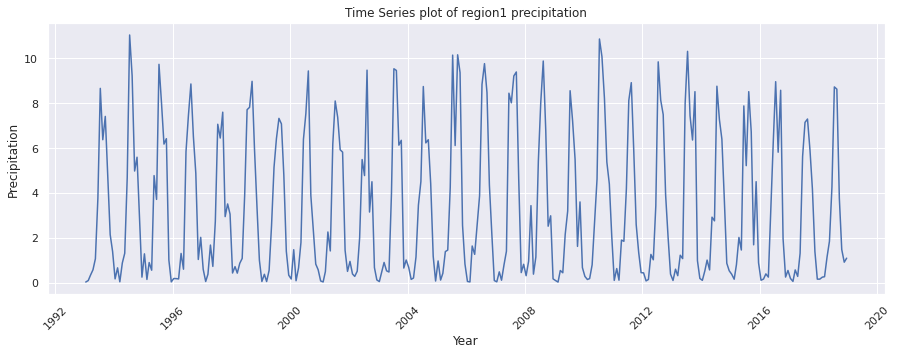

In [8]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,r1_precip, 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of region1 precipitation')
plt.show()

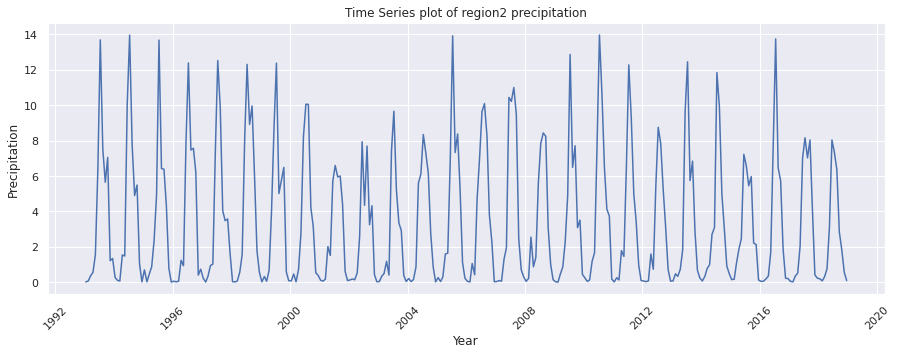

In [9]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,r2_precip, 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of region2 precipitation')
plt.show()

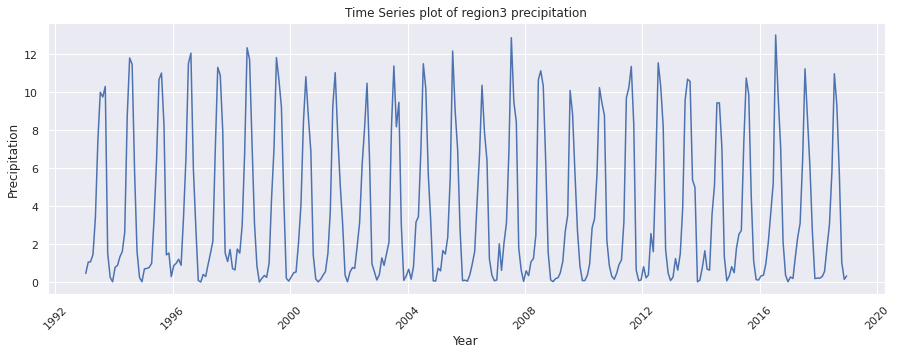

In [10]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,r3_precip, 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of region3 precipitation')
plt.show()

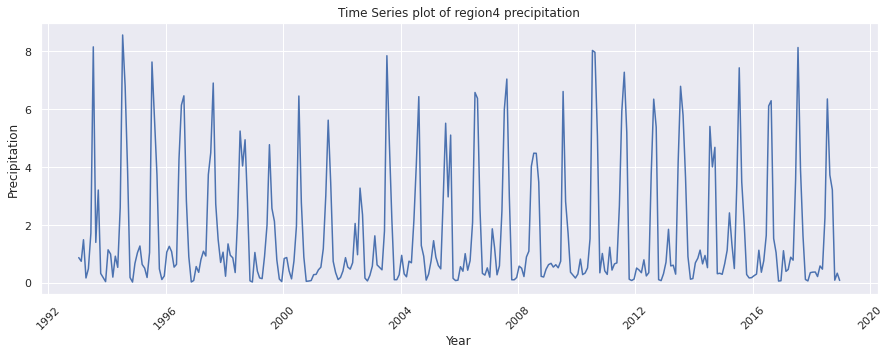

In [11]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,r4_precip, 'b') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of region4 precipitation')
plt.show()

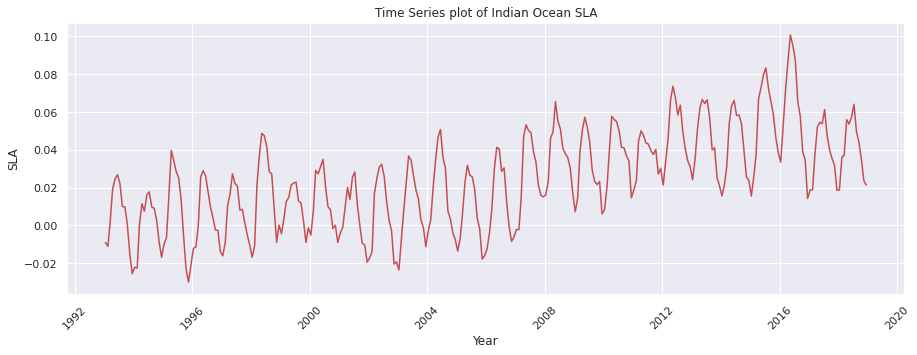

In [12]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,s1, 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('SLA')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Indian Ocean SLA')
plt.show()

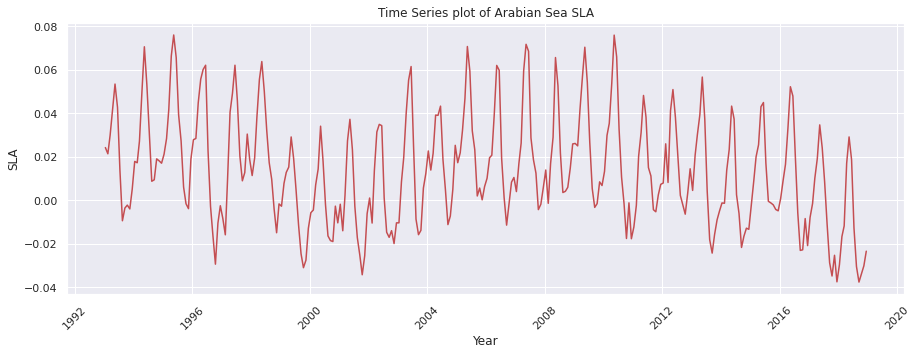

In [13]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,s2, 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('SLA')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Arabian Sea SLA')
plt.show()

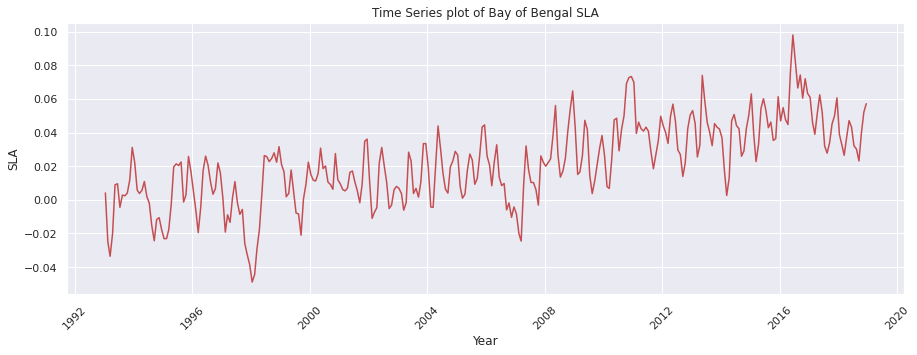

In [14]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(time,s3, 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('SLA')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of Bay of Bengal SLA')
plt.show()

In [15]:
# ONI ENSO INDEX

col = np.arange(13)
data = pd.DataFrame(np.loadtxt("/media/rghoshal/D4A6E10AA6E0EE441/UGP/datasets/oni.txt"),columns=col).set_index(0).stack()
data = pd.DataFrame(data).rename(columns = {0:"oni"})
data = data.reset_index().rename(columns = {0:"year","level_1":"month"})
data = data[data["year"] != 2020]
# data

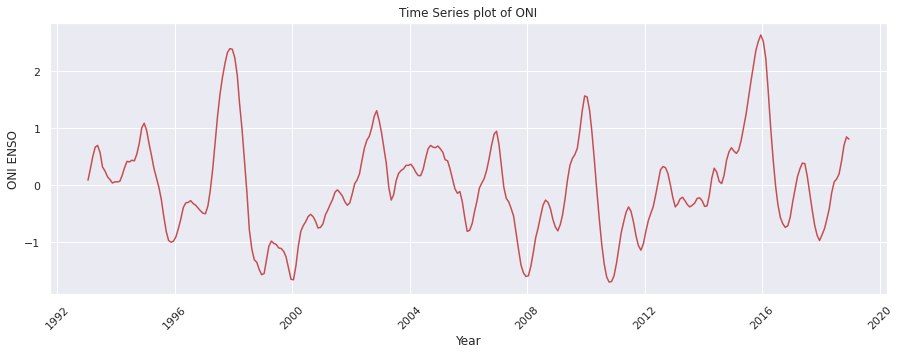

In [16]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(time,data['oni'][(data["year"] > 1992) & (data["year"] < 2019)], 'r') # 'r' is the color red
plt.xlabel('Year')
plt.ylabel('ONI ENSO')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title('Time Series plot of ONI')
plt.show()

In [17]:
import random
from dateutil.parser import parse
from scipy import signal
from scipy.interpolate import interp1d
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.var_model import VAR

In [18]:
df = pd.DataFrame({"precip_SE":np.array(r1_precip),
                   "precip_SW":np.array(r2_precip),
                   "precip_NE":np.array(r3_precip),
                   "precip_NW":np.array(r4_precip),
                   "sla_io":np.array(s1),
                   "sla_as":np.array(s2),
                   "sla_bb":np.array(s3),
                   "enso":np.array(data['oni'][(data["year"] > 1992) & (data["year"] < 2019)])})

In [19]:
df.set_index(time,inplace=True)

In [20]:
stat,p = stats.normaltest(df.precip_NW)
print("Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

Statistics = 83.171, p=0.000
Data looks non-Gaussian (reject null hypothesis)


count    312.000000
mean       3.256447
std        3.204067
min        0.019369
25%        0.516317
50%        1.813522
75%        5.932414
max       11.046390
Name: precip_SE, dtype: float64

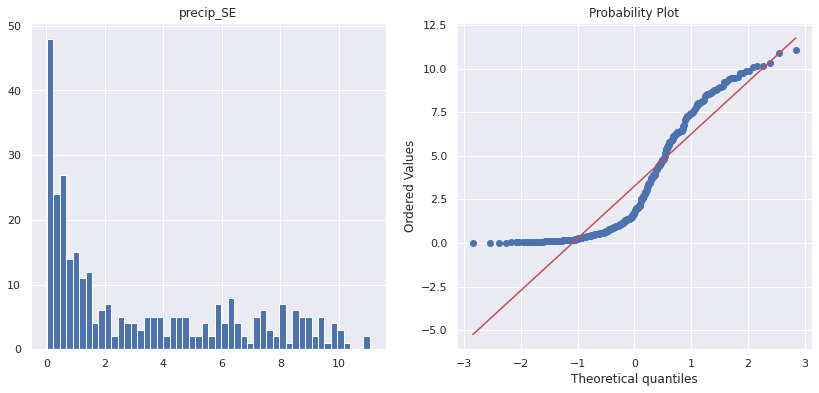

In [21]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['precip_SE'].hist(bins=50)
plt.title('precip_SE')
plt.subplot(1,2,2)
stats.probplot(df['precip_SE'], plot=plt);
df.precip_SE.describe().T

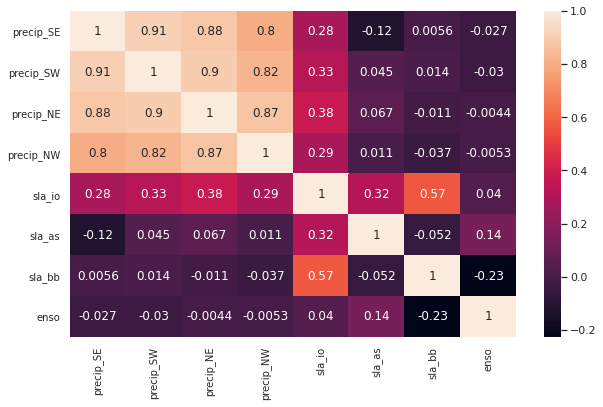

In [22]:
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,annot = True,annot_kws={'size':12})
heatmap = plt.gcf()
heatmap.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

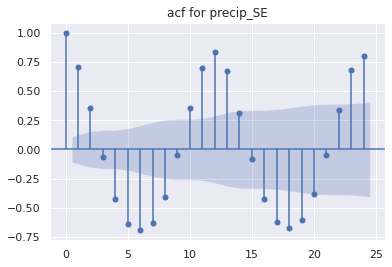

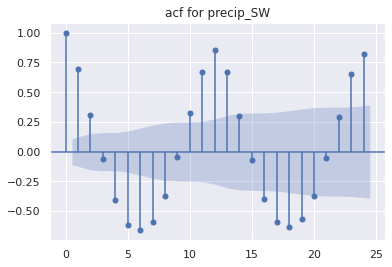

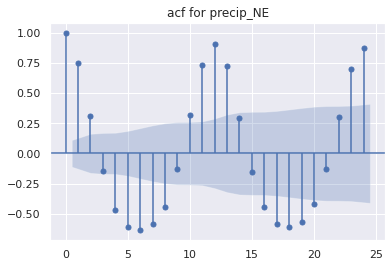

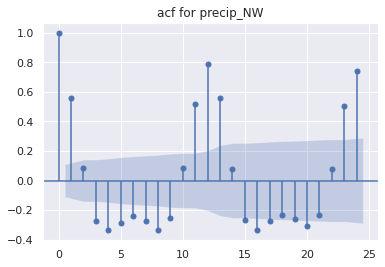

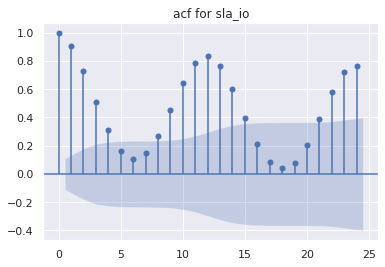

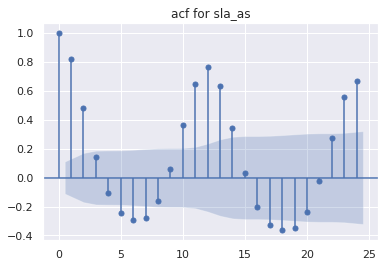

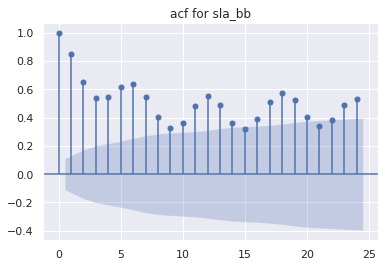

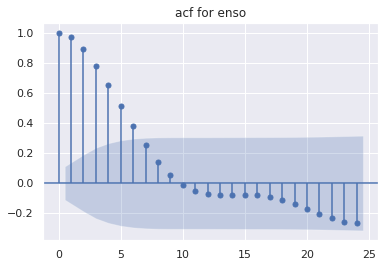

In [23]:
for i in df:
    plot_acf(df[i],lags=24)
    plt.title("acf for "+i )
    plt.show()

In [24]:
n_obs=12
X_train, X_test = df[0:-n_obs], df[-n_obs:]
print(X_train.shape, X_test.shape)
X_train.head()

(300, 8) (12, 8)


,precip_SE,precip_SW,precip_NE,precip_NW,sla_io,sla_as,sla_bb,enso
1993-01-15,0.021624,0.017512,0.470287,0.871136,-0.009085,0.024191,0.004093,0.09
1993-02-15,0.086838,0.065322,1.064722,0.744893,-0.011084,0.021336,-0.025071,0.30
1993-03-15,0.326017,0.348154,1.076788,1.490146,0.001415,0.029823,-0.033581,0.50
1993-04-15,0.568632,0.559666,1.463752,0.168161,0.019108,0.041734,-0.019801,0.67
1993-05-15,1.059878,1.558768,3.400373,0.487609,0.024512,0.053349,0.008861,0.70


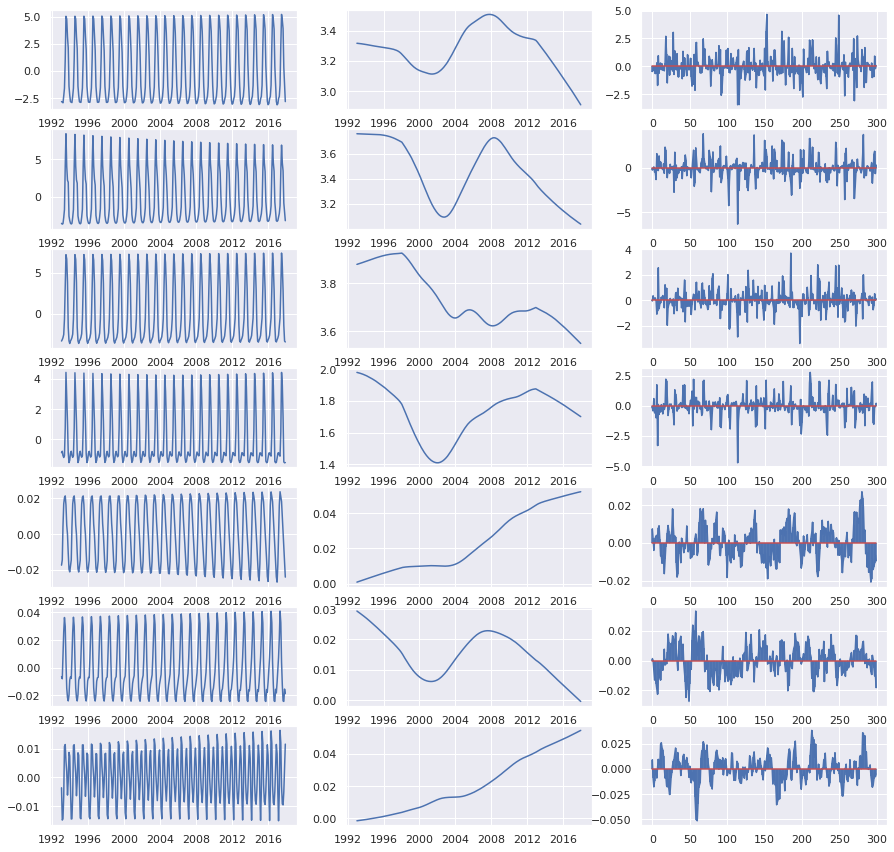

<Figure size 1008x432 with 0 Axes>

In [25]:
from statsmodels.tsa.seasonal import STL
fig, ax = plt.subplots(7,3,figsize=(15, 15))
plt.figure(figsize=(14,6))
transform_data = pd.DataFrame()
for i in range(7): 
    stl = STL(X_train.iloc[:,i], period = 12,seasonal=61 , trend = 121)
    res = stl.fit()
    transform_data[X_train.columns[i]] = res.resid
    ax[i,0].plot(res.seasonal)
    ax[i,1].plot(res.trend)
    ax[i,2].stem(res.resid , markerfmt='')
transform_data[X_train.columns[7]] = X_train.iloc[:,7] 

In [26]:
transform_data.describe()

,precip_SE,precip_SW,precip_NE,precip_NW,sla_io,sla_as,sla_bb,enso
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.006422,0.003825,0.003854,0.001419,0.000047,0.000041,-0.000138,-0.021400
std,1.144396,1.246124,0.877857,0.897895,0.008771,0.010239,0.013914,0.875201
min,-3.463584,-6.365650,-3.398863,-4.726843,-0.020650,-0.027490,-0.051378,-1.700000
25%,-0.586804,-0.504126,-0.386473,-0.339203,-0.006321,-0.006948,-0.009172,-0.590000
50%,-0.126410,-0.093756,-0.051714,-0.049776,-0.000040,0.000297,0.000022,-0.115000
75%,0.468398,0.462808,0.383318,0.273370,0.005569,0.007380,0.008701,0.442500
max,4.663919,3.853023,3.716477,2.773679,0.027014,0.033346,0.038195,2.640000


In [27]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('Augmented Dickey-Fuller Test: Precipitation SE Time Series')
augmented_dickey_fuller_statistics(transform_data['precip_SE'])
print('Augmented Dickey-Fuller Test: Precipitation NW Time Series')
augmented_dickey_fuller_statistics(transform_data['precip_NW'])
print('Augmented Dickey-Fuller Test: Precipitation SW Time Series')
augmented_dickey_fuller_statistics(transform_data['precip_SW'])
print('Augmented Dickey-Fuller Test: Precipitation NE Time Series')
augmented_dickey_fuller_statistics(transform_data['precip_NE'])
print('Augmented Dickey-Fuller Test: SLA Indian Ocean Time Series')
augmented_dickey_fuller_statistics(transform_data['sla_io'])
print('Augmented Dickey-Fuller Test: SLA Bay of bengal Time Series')
augmented_dickey_fuller_statistics(transform_data['sla_bb'])
print('Augmented Dickey-Fuller Test: SLA Arabian sea Time Series')
augmented_dickey_fuller_statistics(transform_data['sla_as'])
print('Augmented Dickey-Fuller Test: ENSO Time Series')
augmented_dickey_fuller_statistics(transform_data['enso'])

Augmented Dickey-Fuller Test: Precipitation SE Time Series
ADF Statistic: -18.643895
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation NW Time Series
ADF Statistic: -15.791403
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation SW Time Series
ADF Statistic: -16.516038
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation NE Time Series
ADF Statistic: -17.383841
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Indian Ocean Time Series
ADF Statistic: -5.232592
p-value: 0.000008
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Bay of bengal Time Series
ADF Statistic: -6.251466
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Arabian sea Time Series
A

In [28]:
print('Augmented Dickey-Fuller Test: Precipitation SE Time Series')
augmented_dickey_fuller_statistics(X_train['precip_SE'])
print('Augmented Dickey-Fuller Test: Precipitation NW Time Series')
augmented_dickey_fuller_statistics(X_train['precip_NW'])
print('Augmented Dickey-Fuller Test: Precipitation SW Time Series')
augmented_dickey_fuller_statistics(X_train['precip_SW'])
print('Augmented Dickey-Fuller Test: Precipitation NE Time Series')
augmented_dickey_fuller_statistics(X_train['precip_NE'])
print('Augmented Dickey-Fuller Test: SLA Indian Ocean Time Series')
augmented_dickey_fuller_statistics(X_train['sla_io'])
print('Augmented Dickey-Fuller Test: SLA Bay of bengal Time Series')
augmented_dickey_fuller_statistics(X_train['sla_bb'])
print('Augmented Dickey-Fuller Test: SLA Arabian sea Time Series')
augmented_dickey_fuller_statistics(X_train['sla_as'])
print('Augmented Dickey-Fuller Test: ENSO Time Series')
augmented_dickey_fuller_statistics(X_train['enso'])

Augmented Dickey-Fuller Test: Precipitation SE Time Series
ADF Statistic: -4.497412
p-value: 0.000199
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation NW Time Series
ADF Statistic: -3.180514
p-value: 0.021141
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation SW Time Series
ADF Statistic: -2.536818
p-value: 0.106771
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: Precipitation NE Time Series
ADF Statistic: -3.892189
p-value: 0.002093
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Indian Ocean Time Series
ADF Statistic: -1.837767
p-value: 0.361879
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Bay of bengal Time Series
ADF Statistic: -1.173020
p-value: 0.685093
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Augmented Dickey-Fuller Test: SLA Arabian sea Time Series
ADF S

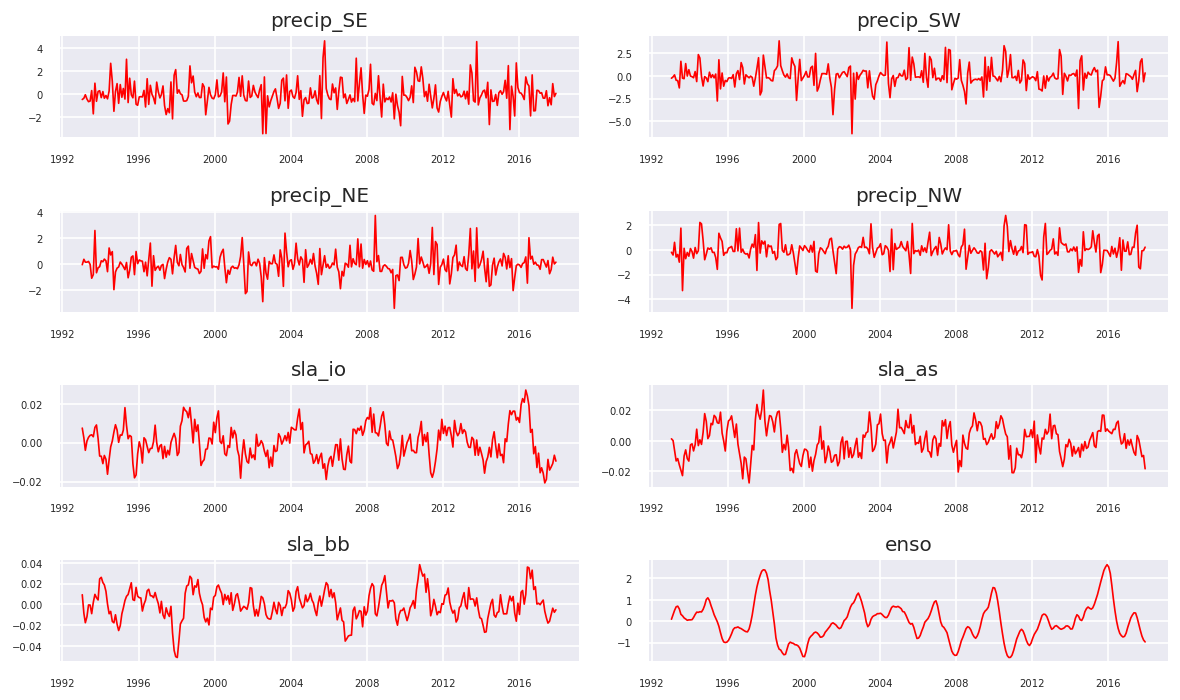

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    d = transform_data[transform_data.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [30]:
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset
grangers_causality_matrix(transform_data, variables = transform_data.columns)

,precip_SE_x,precip_SW_x,precip_NE_x,precip_NW_x,sla_io_x,sla_as_x,sla_bb_x,enso_x
precip_SE_y,1.0000,0.2016,0.1544,0.0199,0.1066,0.0067,0.2014,0.0134
precip_SW_y,0.0038,1.0000,0.1111,0.2044,0.1505,0.0942,0.1398,0.0032
precip_NE_y,0.1470,0.0039,1.0000,0.3144,0.1886,0.1891,0.0751,0.0025
precip_NW_y,0.2094,0.0070,0.0271,1.0000,0.0553,0.0095,0.5379,0.2165
sla_io_y,0.0911,0.4247,0.0202,0.0094,1.0000,0.0151,0.0001,0.0050
sla_as_y,0.0013,0.0003,0.0260,0.1238,0.0096,1.0000,0.0019,0.0001
sla_bb_y,0.0659,0.2182,0.2102,0.5101,0.0019,0.0000,1.0000,0.0000
enso_y,0.0507,0.0598,0.0158,0.4243,0.0563,0.0004,0.0268,1.0000


In [31]:
# import statsmodels
# # transform_data.index = pd.DatetimeIndex(transform_data.index).to_period('M')
# mod = VAR(transform_data[['precip_SE','sla_as']])
# res = mod.select_order(maxlags=12)
# res.summary()

In [32]:
# res = mod.fit(12)
# y_fitted = res.fittedvalues
# plt.figure(figsize = (15,5))
# plt.plot(transform_data.precip_SE, label='resid')
# plt.plot(y_fitted.precip_SE, label='VAR prediction')
# plt.xlabel('Date')
# # plt.xticks(rotation=45)
# plt.ylabel('Residuals')
# plt.grid(True)

In [33]:
# def correlation_pear(x,y):
#     dx = x.transform(lambda x: (x - x.mean()))
#     dy = y.transform(lambda x: (x - x.mean()))
#     return np.sqrt(np.dot(dx.T,dy) / ((dx.T * dx) *(dy.T*dy)))

# correlation_pear(transform_data.precip_SE[3:],y_fitted.precip_SE)

In [34]:
# from statsmodels.stats import stattools
# stattools.durbin_watson(res.resid)

In [35]:
# # Get the lag order
# lag_order = res.k_ar
# input_data = transform_data[['precip_SE','sla_as']].values
# input_data = input_data[-lag_order:]
# input_data[-1]
# # forecasting
# pred = res.forecast(y=input_data, steps=n_obs)
# pred = (pd.DataFrame(pred[:,0], index=X_test[['precip_SE']].index[-n_obs:], columns=X_test[['precip_SE']].columns + '_pred'))
# pred['actual'] = X_test[['precip_SE']]
# pred

In [36]:
# # inverting transformation
# def invert_transformation(X_train, pred):
#     forecast = pred.copy()
#     columns = X_train.columns
#     for col in columns:
        
#         forecast[str(col)+'_pred'] = X_train[str(col)].mean() + X_train[str(col)].std()*forecast[str(col)+'_pred'].cumsum()
#     return forecast

# output = invert_transformation(X_train, pred)
# #combining predicted and real data set
# combine = pd.concat([output['precip_SE_pred'], X_test['precip_SE']], axis=1)
# combine = combine.reset_index()
# # combine = combine.sort_values(by='Date', ascending=False)